<a href="https://colab.research.google.com/github/NitCoh/NLPAss2/blob/master/NLP_Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB


In [2]:
!wget 'https://www.cs.bgu.ac.il/~elhadad/nlp20/hw2_1_data.tar.gz'
!tar -xvzf hw2_1_data.tar.gz
!mv data ../
!wget https://www.cs.bgu.ac.il/~elhadad/nlp20/ngram_counts.txt.gz
!mv ngram_counts.txt.gz ../data/

--2020-01-16 13:04:31--  https://www.cs.bgu.ac.il/~elhadad/nlp20/hw2_1_data.tar.gz
Resolving www.cs.bgu.ac.il (www.cs.bgu.ac.il)... 132.72.41.239
Connecting to www.cs.bgu.ac.il (www.cs.bgu.ac.il)|132.72.41.239|:443... connected.
ERROR: cannot verify www.cs.bgu.ac.il's certificate, issued by ‘CN=Let's Encrypt Authority X3,O=Let's Encrypt,C=US’:
  Unable to locally verify the issuer's authority.
To connect to www.cs.bgu.ac.il insecurely, use `--no-check-certificate'.
tar (child): hw2_1_data.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
mv: cannot stat 'data': No such file or directory
--2020-01-16 13:04:42--  https://www.cs.bgu.ac.il/~elhadad/nlp20/ngram_counts.txt.gz
Resolving www.cs.bgu.ac.il (www.cs.bgu.ac.il)... 132.72.41.239
Connecting to www.cs.bgu.ac.il (www.cs.bgu.ac.il)|132.72.41.239|:443... connected.
ERROR: cannot verify www.cs.bgu.ac.il's certificate, is

In [3]:
#############################################################
## ASSIGNMENT 2_1 CODE SKELETON
#############################################################

from collections import defaultdict
import gzip

#### Q1.1 Evaluation Metrics ####

## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

data_path = '../data'

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
  # For this assignment, complex words 1 are considered positive examples, and simple words 0 are considered negative examples.
    y_pred = [round(y) for y in y_pred]
    tp = len([x for x,y in zip(y_pred,y_true) if x==y==1])
    fp = len([x for x,y in zip(y_pred,y_true) if y==0 and x==1])
    precision = tp/(tp+fp)
    return precision
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
  
    ## YOUR CODE HERE...
    y_pred = [round(y) for y in y_pred]
    tp = len([x for x,y in zip(y_pred,y_true) if x==y==1])
    fn = len([x for x,y in zip(y_pred,y_true) if y==1 and x==0])
    recall = tp/(tp+fn)
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    ## YOUR CODE HERE...
    p = get_precision(y_pred,y_true)
    r = get_recall(y_pred,y_true)
    fscore = 2*p*r / (p +r)
    return fscore

def test_predictions(y_pred,y_true):
    p = get_precision(y_pred,y_true)
    r = get_recall(y_pred,y_true)
    f1 = get_fscore(y_pred,y_true)
    print("Precision:",p)
    print("Recall:",r)
    print("F-score:",f1)
    return p, r, f1

#### 2. Complex Word Identification ####

## Loads in the words and labels of one of the datasets
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

### 1.2.1: A very simple baseline

## Labels every word complex
def all_complex(data_file):
    ## YOUR CODE HERE...
    _, y_true = load_file(data_file)
    y_pred = [1]*len(y_true)
    p, r, f1 = test_predictions(y_pred,y_true)

    performance = [p, r, f1]
    return performance



def threshold_plot_helper(training_file,development_file,pred,ts_range):
    p = []
    r = []
    f1= []
    train_words,train_labels = load_file(training_file)
    for threshold in ts_range:
      y_pred_train = [int(pred(x,threshold)) for x in train_words]
      p_t, r_t, f1_t = test_predictions(y_pred_train,train_labels)
      p.append(p_t)
      r.append(r_t)
      f1.append(f1_t)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.plot(r,p)

    best_index =  f1.index(max(f1))
    best_threshold = ts_range[best_index]
    print("Best threshold:",best_threshold)


    dev_words,dev_labels = load_file(development_file)
    y_pred_dev = [int(pred(x,best_threshold)) for x in dev_words]
    dprecision, drecall, dfscore = test_predictions(y_pred_dev,dev_labels)


    training_performance = [p[best_index], r[best_index], f1[best_index]]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

### 1.2.2: Word length thresholding

## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):

    func = lambda x,threshold: len(x) >= threshold
    return threshold_plot_helper(training_file,development_file,func,range(5,11))

### 1.2.3: Word frequency thresholding

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file): 
   counts = defaultdict(int) 
   with gzip.open(ngram_counts_file, 'rt', errors='ignore') as f: 
       for line in f:
           token, count = line.strip().split('\t') 
           if token[0].islower(): 
               counts[token] = int(count) 
   return counts

# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    func = lambda word,threshold : counts[word] >= threshold

    return threshold_plot_helper(training_file,development_file,func,range(100,8000,100))

### 1.3.1: Naive Bayes
        
def dataset_params(words,counts):
  mean_length = sum([len(word) for word in words])/len(words)
  std_length = sum([len(word) - mean_length for word in words])/len(words)

  mean_counts = sum([counts[word] for word in words])/len(words)
  std_counts = sum([counts[word] - mean_counts for word in words])/len(words)

  return mean_length,std_length,mean_counts,std_counts

## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    

    def get_features(word,params):
      mean_length,std_length,mean_counts,std_counts = params
      l = (len(word) - mean_length) / std_length
      c = (counts[word] - mean_counts) / std_counts
      return [l,c]

    def get_features2(word,params):
      l = len(word)
      c = counts[word]
      return [l,c]


    train_words,train_labels = load_file(training_file)
    params = dataset_params(train_words,counts)
    print("PARAMS:",params)
    X_train = np.array([np.array(get_features(word,params)) for word in train_words])
    y_true_train = np.array(train_labels)
    print("-----------------------------------")
    print(X_train)
    print("-----------------------------------")

    clf = GaussianNB()
    clf.fit(X_train,y_true_train)
    y_pred_train = clf.predict(X_train)
    tprecision, trecall, tfscore = test_predictions(y_pred_train,y_true_train)
    training_performance = [tprecision, trecall, tfscore]

    #dev
    dev_words,dev_labels = load_file(development_file)

    X_test = np.array([np.array(get_features(word,params)) for word in dev_words])
    y_true_test = np.array(dev_labels)

    y_pred_test = clf.predict(X_test)
  
    dprecision, drecall, dfscore = test_predictions(y_pred_test,y_true_test)
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

if __name__ == "__main__":
    training_file = "../data/complex_words_training.txt"
    development_file = "../data/complex_words_development.txt"
    test_file = "../data/complex_words_test_unlabeled.txt"
    train_data = load_file(training_file)
    

FileNotFoundError: ignored

In [0]:
a = np.array([np.array([a,b])for a,b in enumerate([1,2,3,4])])
print(a)

In [0]:
train_file_name = data_path+'/complex_words_training.txt'
dev_file_name = data_path+'/complex_words_development.txt'
test_file_name = data_path+'/complex_words_test_unlabeled.txt'
all_complex(train_file_name)
all_complex(dev_file_name)

In [0]:
word_length_threshold(train_file_name,dev_file_name)

In [0]:
counts = load_ngram_counts(data_path+ngram_path)
avg = sum([val for val in counts.values()])/len(counts)
avg

In [0]:
counts['the']

In [0]:
ngram_path = '/ngram_counts.txt.gz'

word_frequency_threshold(train_file_name,dev_file_name,counts)


Q 1.3 Classifiers

1.3.1 Naive Bayes classification


In [0]:
naive_bayes(train_file_name,dev_file_name,counts)

Q1.4. Ambiguity


In [0]:
from collections import defaultdict

words,labels = load_file(train_file_name)
words_dict = defaultdict(list)
bad_words = []
for word,label in zip(words,labels):
  if word in words_dict and label not in words_dict[word]:
    bad_words.append(word) 
  words_dict[word].append(label)

print(bad_words)


Q2. Document Classification


Q2.1. Reuters Dataset


2.1.1 Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (use the pandas library to explore the dataset, use the dataframe.describe() method.)


**Answer :**
-
number of topics:  445
number of documents:  19716
                  
count    445.000000
mean      89.871910
std      644.656909
min        1.000000
25%        3.000000
50%        8.000000
75%       37.000000
max    12542.000000

 
count    445.000000
mean      89.871910
std      644.656909
min        1.000000
25%        3.000000
50%        8.000000
75%       37.000000
max    12542.000000



2.1.2 Explore how many characters and words are present in the documents of the dataset.


*By exploring the dataset we looked at the body of the articles.


total words: 2498237
total chars: 15089138

2.1.3 Explain informally what are the classifiers that support the "partial-fit" method discussed in the code.

**SGDClassifier**: A linear classifier such as SVM or logistic regression that is trained with SGD algorithm, thus it can support training on mini-batches.

**Perceptron**: A linear classifier which updates its weights iteratively for each example (batch of size 1)

**NB Multinomial**: The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 

**Passive-Agressive**:  The name comes from the fact that we want to reduce loss quickly (aggressive) but we also do not want to overcorrect our weights (passive).

2.1.4 Explain what is the hashing vectorizer used in this tutorial. Why is it important to use this vectorizer to achieve "streaming classification"?


In [3]:
import nltk
nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


True

In [0]:
from nltk.corpus import conll2002


etr = list(conll2002.iob_sents('esp.train')) # In Spanish
eta = list(conll2002.iob_sents('esp.testa')) # In Spanish
etb = list(conll2002.iob_sents('esp.testb'))# In Spanish

dtr = list(conll2002.iob_sents('ned.train')) # In Dutch
dta = list(conll2002.iob_sents('ned.testa')) # In Dutch
dtb = list(conll2002.iob_sents('ned.testb')) # In Dutch

In [5]:
etr[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

3.1.2 Train the model using a logistic regression classifier and experiment with better features - looking at the tags of the previous word, the previous word and the following word (add padding words in the vectorizer)

> Indented block



In [0]:
from urllib.parse import urlparse
import string
puncts = list(string.punctuation) + ['...']

def get_ort(w):
  if w.isdigit():
    return 'number'
  elif any([char.isdigit() for char in w]):
    return 'contains-digit'
  elif w in puncts:
    return 'punctuation'
  elif ('-' in w):
    return 'contains-hyphen'
  elif w.istitle():
    return 'capitalized'
  elif w.isupper():
    return 'all-capitals'
  elif (urlparse(w).scheme) and (urlparse(w).netloc):
    return 'URL'
  else:
    return 'regular'

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]


    features = {
        'word-form': word.lower(),
        'ORT': get_ort(word),
        'POS': postag,
        'suffix3' : word[-3:],
        'suffix2' : word[-2:],
        'suffix1': word[-1:],
        'prefix3': word[:3],
        'prefix2': word[:2],
        'prefix1': word[:1],
    }

    return features



def sent2features(sent,adder):
    return [adder(word2features(sent, i),sent,i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

In [7]:
expected = ['number',
 'contains-digit',
 'punctuation',
 'contains-hyphen',
 'all-capitals',
 'capitalized',
 'URL',
 'regular']

expected == [get_ort(w) for w in ['123','w1',',','hi-hi','SDA','Hello','http://www.google.com','just_word']]

True

In [8]:
sen_triplets = etr[100]
print(' '.join([triplet[0] for triplet in sen_triplets]))
print('-----------------')

print(word2features(sen_triplets,0))
print("---------------------")
sent2labels(sen_triplets)[0]

Imagínense ustedes que entre aquellos españoles , que fueron quienes llevaron a Europa esos dones americanos , se hubiera impuesto la patriotería gastronómica : patatas y tomates se hubieran quedado en curiosidades botánicas .
-----------------
{'word-form': 'imagínense', 'ORT': 'capitalized', 'POS': 'VMM', 'suffix3': 'nse', 'suffix2': 'se', 'suffix1': 'e', 'prefix3': 'Ima', 'prefix2': 'Im', 'prefix1': 'I'}
---------------------


'O'

In [9]:
from enum import Enum  
sets = Enum('sets', ['tr_esp','v_esp','t_esp','tr_dut','v_dut','t_dut'], start=0)

sets.t_dut.value

5

In [0]:

#Identity - base features
def add_features(features,sent,i):
    return features

#Adding prev-word,prev-pos.
def add_features2(features,sent,i):
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            'prev-word-form' : word1.lower(),
            'prev-POS' : postag1,
        })
    else:
        features.update({
            'prev-word-form' : 'BOS',
            'prev-POS' : '<PAD>',
        })
    return features

#Only adding information on the previous word
def add_features3(features,sent,i):
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            'prev-word-form' : word1.lower(),
            'prev-POS' : postag1,
            'prev-ORT': get_ort(word1),
            'prev-suffix3' : word1[-3:],
            'prev-suffix2' : word1[-2:],
            'prev-suffix1': word1[-1:],
            'prev-prefix3': word1[:3],
            'prev-prefix2': word1[:2],
            'prev-prefix1': word1[:1],
        })
    else:
        features.update({
            'prev-word-form' : 'BOS',
            'prev-POS' : '<PAD>',
            'prev-ORT': '~',
            'prev-suffix3' : '~',
            'prev-suffix2' : '~',
            'prev-suffix1': '~',
            'prev-prefix3': '~',
            'prev-prefix2': '~',
            'prev-prefix1': '~',
        })
    return features

#Adding information on the previous word
#Plus adding information on the next word
def add_features4(features,sent,i):
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            'prev-word-form' : word1.lower(),
            'prev-POS' : postag1,
        })
    else:
        features.update({
            'prev-word-form' : 'BOS',
            'prev-POS' : '<PAD>',
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            'next-word-form' : word1.lower(),
        })
    else:
        features.update({
            'next-word-form': 'EOS'
            })
    return features


def add_features5(features,sent,i):
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            'prev-word-form' : word1.lower(),
            'prev-POS' : postag1,
            'prev-ORT': get_ort(word1),
            'prev-suffix3' : word1[-3:],
            'prev-suffix2' : word1[-2:],
            'prev-suffix1': word1[-1:],
            'prev-prefix3': word1[:3],
            'prev-prefix2': word1[:2],
            'prev-prefix1': word1[:1],
        })
    else:
        features.update({
            'prev-word-form' : 'BOS',
            'prev-POS' : '<PAD>',
            'prev-ORT': '~',
            'prev-suffix3' : '~',
            'prev-suffix2' : '~',
            'prev-suffix1': '~',
            'prev-prefix3': '~',
            'prev-prefix2': '~',
            'prev-prefix1': '~',
        })


      
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            'next-word-form' : word1.lower(),
        })
    else:
        features.update({
            'next-word-form': 'EOS'
            })
    return features






In [0]:

from functools import reduce
flatten = lambda l: reduce(lambda x,y: x+y,l)



data_set = [etr,eta,etb]

add_funcs = [add_features,add_features2,add_features3,add_features4,add_features5]

y_data_set = list(map(lambda x: flatten([sent2labels(s) for s in x]),data_set))


xtr_xv_xt = []


for func in add_funcs:
  x_data_set = list(map(lambda x: flatten([sent2features(s,func) for s in x]),data_set))
  X_train_esp = x_data_set[sets.tr_esp.value]
  X_valid_esp = x_data_set[sets.v_esp.value]
  X_test_esp = x_data_set[sets.t_esp.value]
  xtr_xv_xt.append((X_train_esp,X_valid_esp,X_test_esp))


y_train_esp = y_data_set[sets.tr_esp.value]
y_valid_esp = y_data_set[sets.v_esp.value]
y_test_esp = y_data_set[sets.t_esp.value]




In [12]:
xtr,xv,xt = xtr_xv_xt[0]
xtr[0]

{'ORT': 'capitalized',
 'POS': 'NP',
 'prefix1': 'M',
 'prefix2': 'Me',
 'prefix3': 'Mel',
 'suffix1': 'e',
 'suffix2': 'ne',
 'suffix3': 'rne',
 'word-form': 'melbourne'}

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
regressors = []
vectorizers = []

for xtr, xv, xt in xtr_xv_xt:
  v = DictVectorizer(sparse=True)
  X = v.fit_transform(xtr)
  Y = y_train_esp
  try:
    clf = LogisticRegression(random_state=0,max_iter=200).fit(X, Y)
  except Exception as e:
    print(e)
    continue
  vectorizers.append(v)
  regressors.append(clf)
  print("Predicted:",clf.predict(X[0]))



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Predicted: ['B-LOC']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Predicted: ['B-LOC']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Predicted: ['B-LOC']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Predicted: ['B-LOC']
Predicted: ['B-LOC']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def plot_conf_mat(clf,X,Y):
  np.set_printoptions(precision=2)
  titles_options = [("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
      disp = plot_confusion_matrix(clf, X, Y,
                                  display_labels=clf.classes_,
                                  cmap=plt.cm.Blues,
                                  normalize='true')
      disp.ax_.set_title(title)
      print(title)
  plt.show()

def plot_prec_recall_fmeasure(clf,X,Y):
  y_pred = np.array([clf.predict(x) for x in X])
  y_true = np.array(Y)
  print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

In [16]:
  vec_t = vectorizers[0]
  xsd = vec_t.transform(xtr_xv_xt[0][0])
  plot_confusion_matrix(regressors[0],xsd,y_test_esp)

ValueError: ignored

(0.6357606937753099, 0.5534568625163332, 0.5757265297673584, None)
(0.7095743918121802, 0.644892603933354, 0.6667976333902809, None)
(0.735104790578652, 0.6900717204233757, 0.707412139018423, None)
(0.7167309425746171, 0.6524462308913921, 0.6752992699796487, None)
(0.7410270667689048, 0.6960736502200778, 0.7131931717396419, None)


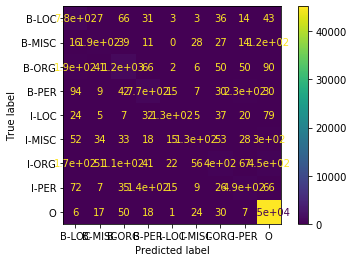

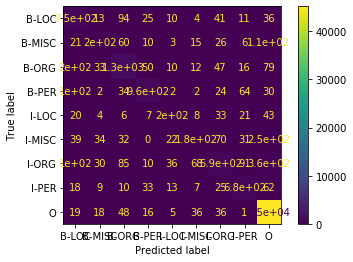

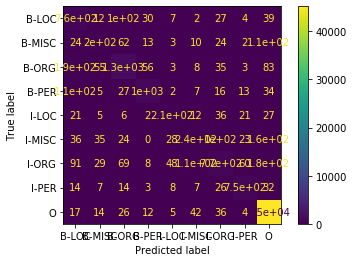

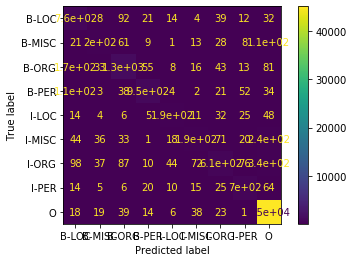

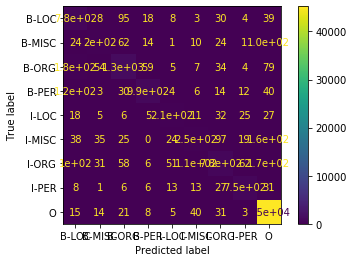

In [15]:

for i, (xtr, xv, xt) in enumerate(xtr_xv_xt):
  v = vectorizers[i]
  clf = regressors[i]
  X = v.transform(xv)
  plot_confusion_matrix(clf,X,y_valid_esp)
  plot_prec_recall_fmeasure(clf,X,y_valid_esp)

In [0]:
#ADD the best model with all the stuff

3.1.3

In [0]:
def is_o_ix(w1,w2):
  return w1[0] == 'O' and w2[0] == 'I'
def is_ix_iy(w1,w2):
  return w1[:2] != w2[:2]
def is_bx_iy(w1,w2):
  return w1[0] == 'B' and w2[0] == 'I' and w1[:2] != w2[:2]

def transform_predict(vectorizer,clf,w_dict):
  w = vectorizer.transform(w_dict)
  return clf.predict(w)

def sen_to_predicts(vectorizer,clf,sen,adder):
  return [clf.transform_predict(w_dict) for w_dict in sent2features(sen,adder)]

#Get the raw data X, trained regressor, vectorizer used for the features, adder used for the features.
def bad_BIO_tags(clf,X,vectorizer,adder):
  sents_pred = [sen_to_predicts(vectorizer,clf,sen,adder) for sen in X]
  cts = {
    "cOIX": 0
    "cIXIY": 0
    "cBXIY": 0
  }
  for sen in sents_pred:
    cOIX = 0
    cIXIY = 0
    cBXIY = 0
    for w1,w2 in zip(sen,sen[1:]):
      if is_o_ix(w1,w2):
        cIOX+=1
      elif is_ix_iy(w1,w2):
        cIXIY+=1
      elif is_bx_iy(w1,w2):
        cBXIY+=1
    cts["cOIX"] += (cIOX /len(sen))
    cts["cIXIY"] += (cIXIY /len(sen))
    cts["cBXIY"] += (cBXIY /len(sen))

 for key,val in cts:
   cts[key] = cts[key]/len(sents_pred)

  return cts



In [42]:
!pip install fasttext

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2385495 sha256=68166b96429109fcf4f03e2b46e45d4d6f7443aa08bec7c6796dd1941e1e2fce
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


In [48]:
pip install gensim

In [56]:
!wget http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz

--2020-01-16 18:55:08--  http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz [following]
--2020-01-16 18:55:09--  https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1123304474 (1.0G) [application/x-gzip]
Saving to: ‘SBW-vectors-300-min5.bin.gz’

SBW-vectors-300-min 100%[===================>]   1.05G  17.8MB/s    in 62s     

2020-01-16 18:56:12 (17.2 MB/s) - ‘SBW-vectors-300-min5.bin.gz’ saved [1123304474/1123304474]



In [0]:
!gunzip  SBW-vectors-300-min5.bin.gz
#download word2vec embedding

In [62]:
!ls

sample_data  SBW-vectors-300-min5.bin


In [65]:
from gensim.models import Word2Vec,KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('SBW-vectors-300-min5.bin',binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [109]:
word_vectors['cat'].shape

(300,)

In [0]:
non_embed = np.array([0.0]*300,dtype='float32')

def get_from_word_dic(word):
  try:
    return word_vectors[word]
  except:
    return non_embed



def add_features_embeds(features, sent, i):
  word = sent[i][0]
  postag = sent[i][1]
  features.update({
      'word-embed': get_from_word_dic(word)
  })


  if i > 0:
    word1 = sent[i - 1][0]
    postag1 = sent[i - 1][1]
    features.update({
        'prev-word-embed': get_from_word_dic(word1),
        'prev-word-form': word1.lower(),
        'prev-POS': postag1,
        'prev-ORT': get_ort(word1),
        'prev-suffix3': word1[-3: ],
        'prev-suffix2': word1[-2: ],
        'prev-suffix1': word1[-1: ],
        'prev-prefix3': word1[: 3],
        'prev-prefix2': word1[: 2],
        'prev-prefix1': word1[: 1],
    })
  else :
    features.update({
        'prev-word-embed': np.array([0.0] * 300),
        'prev-word-form': 'BOS',
        'prev-POS': '<PAD>',
        'prev-ORT': '~',
        'prev-suffix3': '~',
        'prev-suffix2': '~',
        'prev-suffix1': '~',
        'prev-prefix3': '~',
        'prev-prefix2': '~',
        'prev-prefix1': '~',
    })

  if i < len(sent) - 1:
    word1 = sent[i + 1][0]
    postag1 = sent[i + 1][1]
    features.update({
        'next-word-embed': get_from_word_dic(word1),
        'next-word-form': word1.lower(),
    })
  else :
    features.update({
        'next-word-embed': np.array([0.0] * 300),
        'next-word-form': 'EOS'
    })

  return features

In [0]:
def embed_set(data):
  return np.array([get_from_word_dic(w) for sen in data for w,_,_ in sen])

data_set_embeds = list(map(lambda x:embed_set(x) , data_set))

#Best f_measure according to measurements
X_train_esp_emb,X_valid_esp_emb,X_test_esp_emb = xtr_xv_xt[-1]


# x_data_set_emb = list(map(lambda x: flatten([sent2features(s,add_features_embeds) for s in x]),data_set))
# X_train_esp_emb = x_data_set_emb[sets.tr_esp.value]
# X_valid_esp_emb = x_data_set_emb[sets.v_esp.value]
# X_test_esp_emb = x_data_set_emb[sets.t_esp.value]

In [133]:
data_set_embeds[0].shape

(264715, 300)

In [1]:
dic_v = DictVectorizer(sparse=True)
X = dic_v.fit_transform(X_train_esp_emb)
print(X)

# X = np.concatenate((X,data_set_embeds[0]), axis=1)
# X.shape

  # Y = y_train_esp
  # try:
  #   clf_embed = LogisticRegression(random_state=0,max_iter=200).fit(X, Y)
  # except Exception as e:
  #   print(e)
  # print("Predicted:",clf_embed.predict(X[0]))




NameError: ignored

(0.7410270667689048, 0.6960736502200778, 0.7131931717396419, None)


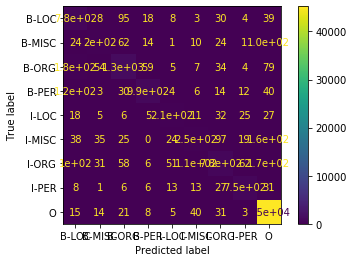

In [87]:
  xv_embed = v.transform(X_valid_esp_emb)
  plot_confusion_matrix(clf,xv_embed,y_valid_esp)
  plot_prec_recall_fmeasure(clf,xv_embed,y_valid_esp)